In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [80]:
# Prepare dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

target = 'fuel_efficiency_mpg'

categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index)
df[numerical] = df[numerical].fillna(0.0)


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

del df_train[target]
del df_val[target]
del df_test[target]

from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)

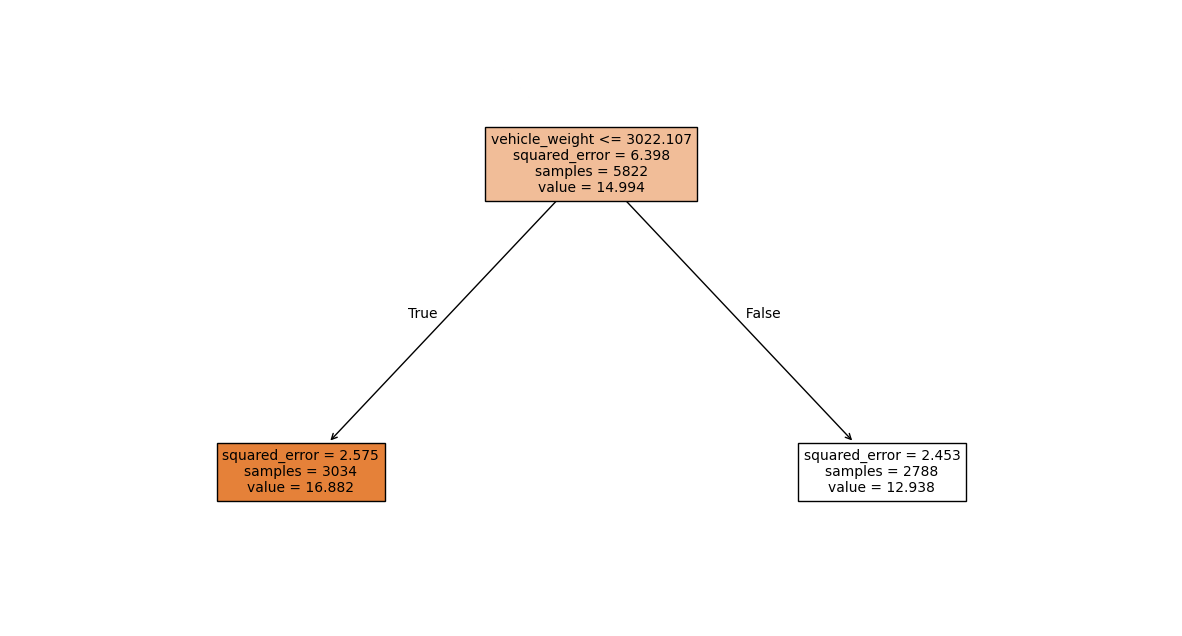

In [81]:
# Question 1 - Train DT regression model

from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

X_val = dv.transform(val_dicts)
y_pred = dtr.predict(X_val)

from sklearn.tree import plot_tree

plt.figure(figsize=(15, 8))
plot_tree(dtr,
        feature_names=dv.get_feature_names_out(),
        filled=True,
        fontsize=10)
plt.show()


In [82]:
# Question 2 - RFR

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rfr_params = {
    'n_estimators':10,
    'random_state':1,
    'n_jobs':-1
}

rfr = RandomForestRegressor(**rfr_params)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
print(f"RMSE: {rmse:.2f}")


RMSE: 0.46


n_estimators= 10, RMSE=0.459
n_estimators= 20, RMSE=0.454
n_estimators= 30, RMSE=0.451
n_estimators= 40, RMSE=0.448
n_estimators= 50, RMSE=0.446
n_estimators= 60, RMSE=0.445
n_estimators= 70, RMSE=0.445
n_estimators= 80, RMSE=0.445
n_estimators= 90, RMSE=0.445
n_estimators=100, RMSE=0.445
n_estimators=110, RMSE=0.444
n_estimators=120, RMSE=0.444
n_estimators=130, RMSE=0.444
n_estimators=140, RMSE=0.444
n_estimators=150, RMSE=0.443
n_estimators=160, RMSE=0.443
n_estimators=170, RMSE=0.443
n_estimators=180, RMSE=0.443
n_estimators=190, RMSE=0.443
n_estimators=200, RMSE=0.443


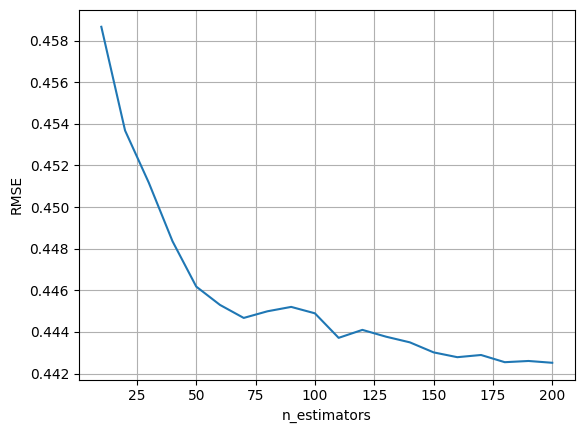


Minimum RMSE: 0.443
First occurs at n_estimators: 150


In [83]:
# Question 3 - Find when RMSE stops improving

rmses = []
n_estimators_range = range(10, 210, 10)  # 10 to 200 with step 10

for n_estimator in n_estimators_range:
    rfr_params['n_estimators'] = n_estimator
    rfr = RandomForestRegressor(**rfr_params)
    
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    rmses.append(rmse)
    print(f"n_estimators={n_estimator:3d}, RMSE={rmse:.3f}")

# Plot
plt.plot(n_estimators_range, rmses)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Find when RMSE stops improving (reaches minimum)
rmses_rounded = [round(r, 3) for r in rmses]
min_rmse = min(rmses_rounded)
min_idx = rmses_rounded.index(min_rmse)
best_n_estimators = list(n_estimators_range)[min_idx]

print(f"\nMinimum RMSE: {min_rmse:.3f}")
print(f"First occurs at n_estimators: {best_n_estimators}")

max_depth=10, mean RMSE=0.442, std RMSE=0.003
max_depth=15, mean RMSE=0.446, std RMSE=0.004
max_depth=20, mean RMSE=0.446, std RMSE=0.004
max_depth=25, mean RMSE=0.446, std RMSE=0.004


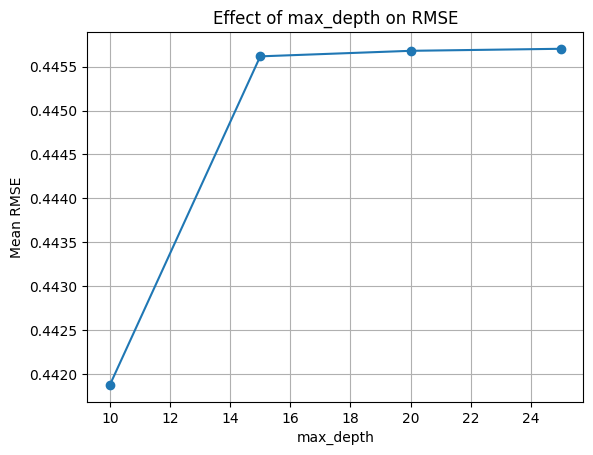


Best max_depth: 10
Lowest mean RMSE: 0.442


In [84]:
# Question 4

result = {}

for depth in [10, 15, 20, 25]:
    rmses = []
    rfr_params['max_depth'] = depth  # Set max_depth!
    
    for n_estimator in range(10, 210, 10):
        rfr_params['n_estimators'] = n_estimator
        rfr = RandomForestRegressor(**rfr_params)
        
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_val)
        
        rmse = root_mean_squared_error(y_val, y_pred)
        rmses.append(rmse)
    
    result[depth] = rmses
    print(f"max_depth={depth}, mean RMSE={np.mean(rmses):.3f}, std RMSE={np.std(rmses):.3f}")

# Plot depth vs mean RMSE
depths = list(result.keys())
mean_rmses = [np.mean(result[d]) for d in depths]

plt.plot(depths, mean_rmses, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean RMSE')
plt.title('Effect of max_depth on RMSE')
plt.grid()
plt.show()

# Find which depth has lowest mean RMSE
best_depth_idx = np.argmin(mean_rmses)
best_depth = depths[best_depth_idx]
print(f"\nBest max_depth: {best_depth}")
print(f"Lowest mean RMSE: {mean_rmses[best_depth_idx]:.3f}")

In [96]:
# Question 5

rfr_params = {
    'n_estimators':10,
    'max_depth': 20,
    'random_state':1,
    'n_jobs':-1
}

rfr = RandomForestRegressor(**rfr_params)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_val)

feature_importance = rfr.feature_importances_
feature_names = dv.get_feature_names_out()

zipped =zip(feature_importance, feature_names)
sorted(zipped, key=lambda x: x[1], reverse=True)



[(np.float64(0.9591531737242687), 'vehicle_weight'),
 (np.float64(0.0005464313271065868), 'origin=USA'),
 (np.float64(0.000512930005160041), 'origin=Europe'),
 (np.float64(0.0004539757777347394), 'origin=Asia'),
 (np.float64(0.0016176974417593248), 'num_doors'),
 (np.float64(0.0023334152615241094), 'num_cylinders'),
 (np.float64(0.003170182269366206), 'model_year'),
 (np.float64(0.01606583100118693), 'horsepower'),
 (np.float64(0.0003504405330845204), 'fuel_type=Gasoline'),
 (np.float64(0.0003364129074839335), 'fuel_type=Diesel'),
 (np.float64(0.0032794702827490425), 'engine_displacement'),
 (np.float64(0.00033911976576736947), 'drivetrain=Front-wheel drive'),
 (np.float64(0.00035125918578910635), 'drivetrain=All-wheel drive'),
 (np.float64(0.011489660517019416), 'acceleration')]

In [102]:
# Question 6

import xgboost as xgb

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

features = list(feature_names)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


result = {}

for eta in [0.3, 0.1]:
    xgb_params['eta'] = eta
    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    y_pred = model.predict(dval)
    rmse = root_mean_squared_error(y_val, y_pred)
    result[eta] = rmse

result

{0.3: 0.45017755678087246, 0.1: 0.42622800553359225}